# Evaluación inicial de modelos de audio TensorFlow Lite

Este notebook sirve para probar el funcionamiento de un modelo de audio TensorFlow Lite.
## Imports

In [1]:
import tensorflow as tf
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time

from audio_model_evaluation import get_dataset, DIGITS

## Parámetros
Parámetros que se utilizan para el test.

In [2]:
quantized = True
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/audio"
label_index_dir = f"{saved_models_dir}/label index mappings"
# model_name = f"ExtAudioDataModel"
model_name = f"ExtAudioDataModelQAT"

label_index_path = f"{label_index_dir}/{model_name}.joblib"
test_dir = f"{project_dir}/samples/external/audio/test"

if quantized and model_name[-3:] != "QAT":
    model_name = f"{model_name}Quant"

model_path = f"{saved_models_dir}/tensorflow lite/{model_name}.tflite"

## Carga del modelo
Cargamos un modelo de TensorFlow Lite.

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(input_details)
print(output_details)

class_names = load(label_index_path)
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 40, 49,  1], dtype=int32), 'shape_signature': array([-1, 40, 49,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.015708986669778824, 85), 'quantization_parameters': {'scales': array([0.01570899], dtype=float32), 'zero_points': array([85], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 11, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.31582218408584595, 194), 'quantization_parameters': {'scales': array([0.31582218], dtype=float32), 'zero_points': array([194], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


## Carga de datos

Cargamos los datos que se utilizarán para el entrenamiento.

In [4]:
test_dataset = get_dataset(test_dir, prefetch=False)
test_dataset = test_dataset.as_numpy_iterator()

Using 3230 samples.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

In [5]:
predictions = []
true_labels = []
times = []

for spectrogram, label in test_dataset:
    true_labels.append(label)

    if quantized:
        input_scale, input_zero_point = input_details["quantization"]
        spectrogram = spectrogram / input_scale + input_zero_point
    spectrogram = np.expand_dims(spectrogram, axis=0).astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], spectrogram)

    t_ini = time.time()
    interpreter.invoke()
    t_end = time.time()
    elapsed = (t_end - t_ini) * 1000  # ms
    times.append(elapsed)

    prediction = interpreter.get_tensor(output_details["index"])[0]

    predicted_class = prediction.argmax()
    predictions.append(predicted_class)

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

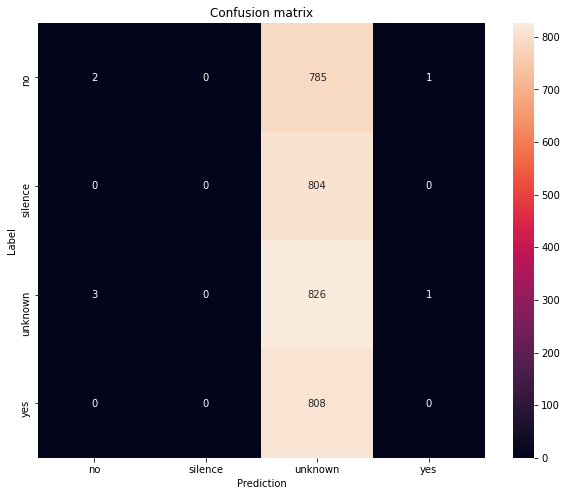

              precision    recall  f1-score   support

          no    0.40000   0.00254   0.00504       788
     silence    0.00000   0.00000   0.00000       804
     unknown    0.25628   0.99518   0.40760       830
         yes    0.00000   0.00000   0.00000       808

    accuracy                        0.25635      3230
   macro avg    0.16407   0.24943   0.10316      3230
weighted avg    0.16344   0.25635   0.10597      3230

Model size 6.1328125 Kb
Average time: 1.5775750665103687 ms
Max time: 13.411760330200195 ms
Min time: 0.6334781646728516 ms
Quantized models perform slower as they are intended to work on ARM devices.


/home/daniel/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daniel/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daniel/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(true_labels, predictions, target_names=class_names, digits=DIGITS))

avg_time = sum(times) / len(times)
max_time = max(times)
min_time = min(times)

print(f"Model size {os.path.getsize(model_path) / 1024} Kb")

print(f"Average time: {avg_time} ms\nMax time: {max_time} ms\nMin time: {min_time} ms")

if quantized:
    print("Quantized models perform slower as they are intended to work on ARM devices.")